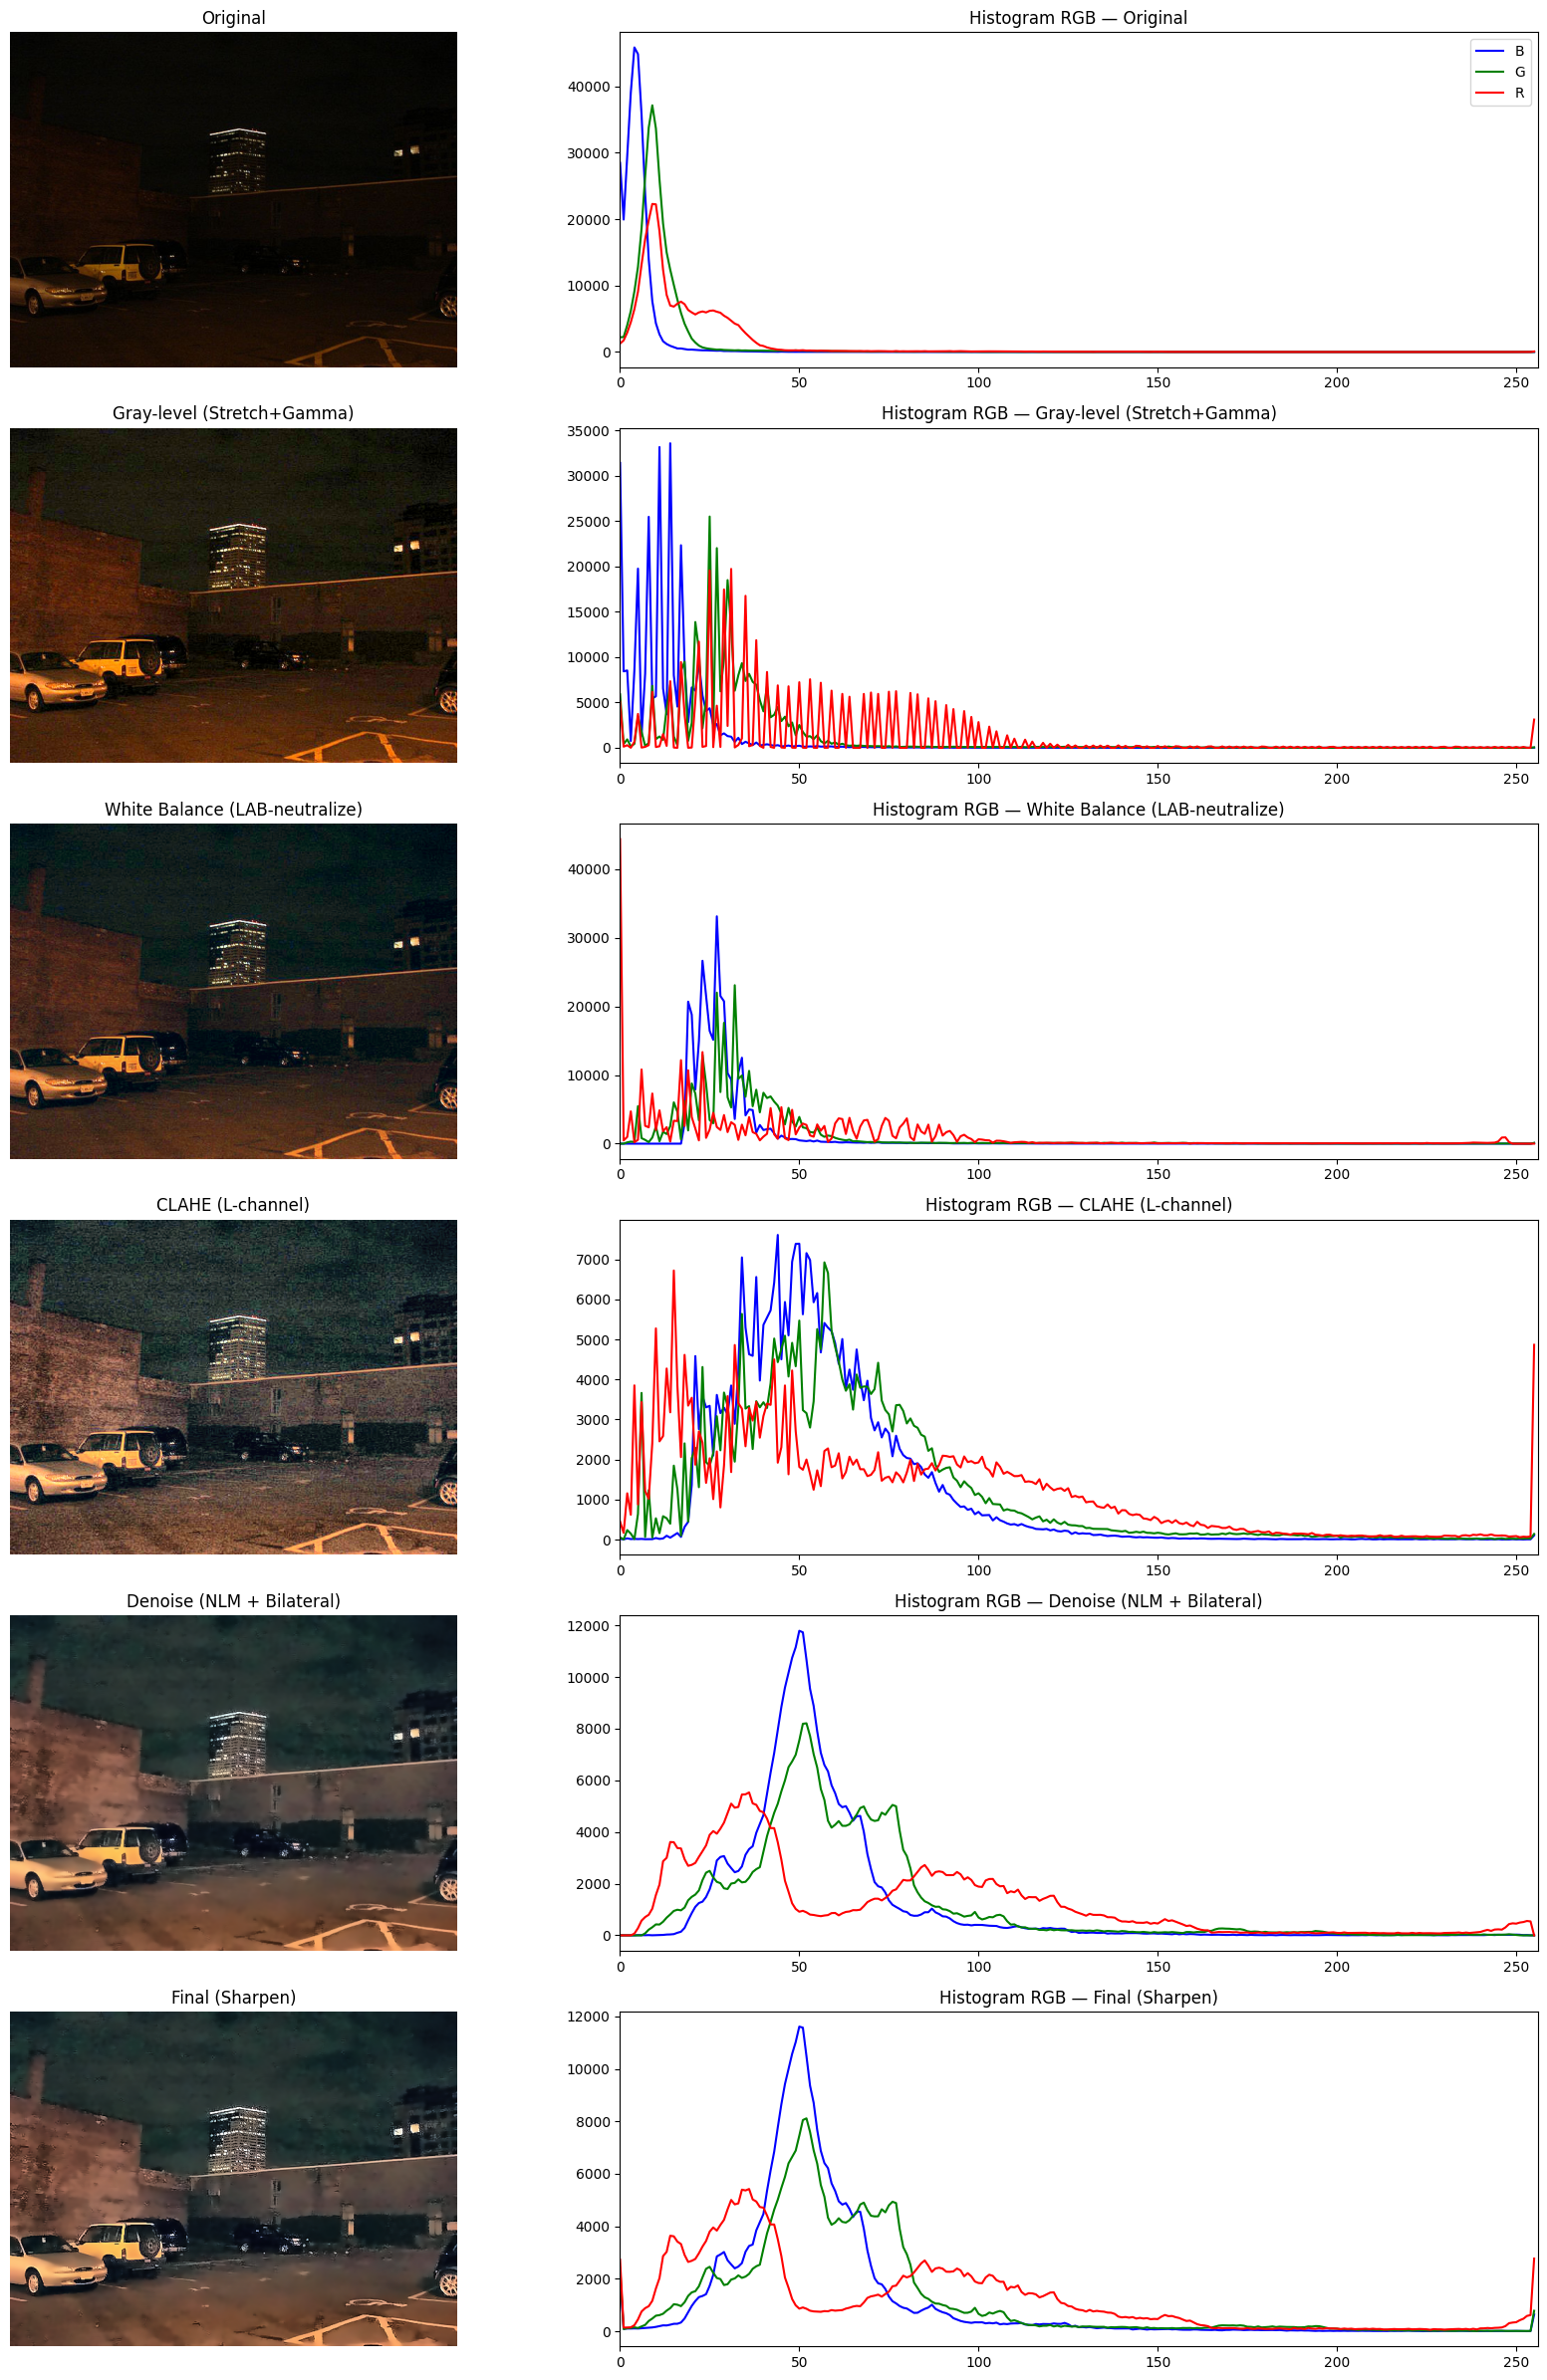

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ========= Helper =========
def rgb_hist(img_bgr):
    hists = []
    for i in range(3):
        h = cv2.calcHist([img_bgr], [i], None, [256], [0, 256])
        hists.append(h)
    return hists

def contrast_stretch_v(img_bgr, low_p=1.0, high_p=99.0):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    V = hsv[..., 2]
    p_low  = np.percentile(V, low_p)
    p_high = np.percentile(V, high_p)
    if p_high <= p_low:  # fallback aman
        return img_bgr.copy()
    V = (V - p_low) / (p_high - p_low)
    V = np.clip(V, 0, 1) * 255.0
    hsv[..., 2] = V
    out = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return out

def gamma_correction_v(img_bgr, gamma=0.8):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    V = hsv[..., 2] / 255.0
    V = np.power(np.clip(V, 0, 1), gamma)
    hsv[..., 2] = (np.clip(V, 0, 1) * 255.0)
    out = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return out

def white_balance_lab_neutralize(img_bgr, strength=1.0):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    A = A.astype(np.float32); B = B.astype(np.float32)
    mean_a = float(np.mean(A)); mean_b = float(np.mean(B))
    A = A - strength * (mean_a - 128.0)
    B = B - strength * (mean_b - 128.0)
    A = np.clip(A, 0, 255).astype(np.uint8)
    B = np.clip(B, 0, 255).astype(np.uint8)
    lab_corr = cv2.merge([L, A, B])
    return cv2.cvtColor(lab_corr, cv2.COLOR_LAB2BGR)

def clahe_on_L(img_bgr, clipLimit=3.0, tileGridSize=(6,6)):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    Lc = clahe.apply(L)
    lab_c = cv2.merge([Lc, A, B])
    out = cv2.cvtColor(lab_c, cv2.COLOR_LAB2BGR)
    return out

def bilateral_denoise(img_bgr, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img_bgr, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

def _gauss_ksize_from_sigma(sigma):
    k = int(max(3, round(sigma * 6 + 1)))
    return k + 1 if k % 2 == 0 else k

def unsharp_mask(img_bgr, radius=1.2, amount=1.2, threshold=3):
    img = img_bgr.astype(np.float32)
    sigma = max(0.1, float(radius))
    ksize = _gauss_ksize_from_sigma(sigma)
    blur = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT)

    mask = img - blur
    if threshold > 0:
        thr = np.full_like(mask, float(threshold))
        mask[np.abs(mask) < thr] = 0.0

    sharp = img + float(amount) * mask
    sharp = np.clip(sharp, 0, 255).astype(np.uint8)
    return sharp

# ========= 0) Load =========
path = "data/car01.jpg"
img_bgr = cv2.imread(path)
assert img_bgr is not None, "Gambar tidak ditemukan. Cek path!"

# ========= 1) Gray-level Transformation =========
img_gray_cs = contrast_stretch_v(img_bgr, low_p=1.0, high_p=99.0)  
img_gray    = gamma_correction_v(img_gray_cs, gamma=0.8)         

# ========= 2) White Balance (LAB neutralization) =========
img_wb = white_balance_lab_neutralize(img_gray, strength=0.6)      

# ========= 3) CLAHE (L-channel) =========
img_clahe = clahe_on_L(img_wb, clipLimit=2.5, tileGridSize=(6,6))

# ========= 4) Denoise (NLM + Bilateral) =========
img_denoise = cv2.fastNlMeansDenoisingColored(
    img_clahe, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21
)
img_bilateral = bilateral_denoise(img_denoise, d=9, sigmaColor=75, sigmaSpace=75)

# ========= 5) Sharpening (Unsharp Mask) =========
img_sharp = unsharp_mask(img_bilateral, radius=1.0, amount=1.0, threshold=5)
cv2.bilateralFilter(img_sharp, d=5, sigmaColor=30, sigmaSpace=30)

# ========= Simpan hasil =========
cv2.imwrite("result_01_graylevel.jpg", img_gray)
cv2.imwrite("result_02_whitebalance.jpg", img_wb)
cv2.imwrite("result_03_clahe_L.jpg", img_clahe)
cv2.imwrite("result_04_denoise_bilateral.jpg", img_bilateral)
cv2.imwrite("result_05_final_sharpen.jpg", img_sharp)

# ========= Plot: Asli vs Gray-level vs WB vs CLAHE vs Denoise vs Final =========
titles = [
    "Original", "Gray-level (Stretch+Gamma)", "White Balance (LAB-neutralize)",
    "CLAHE (L-channel)", "Denoise (NLM + Bilateral)", "Final (Sharpen)"
]
imgs = [img_bgr, img_gray, img_wb, img_clahe, img_bilateral, img_sharp]

rows = len(imgs)
plt.figure(figsize=(18, 4*rows))

# Gambar
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    plt.subplot(rows, 2, 2*i - 1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(t)
    plt.axis('off')

# Histogram RGB
for i, (t, im) in enumerate(zip(titles, imgs), 1):
    hB, hG, hR = rgb_hist(im)
    plt.subplot(rows, 2, 2*i)
    plt.plot(hB, color='blue', label='B')
    plt.plot(hG, color='green', label='G')
    plt.plot(hR, color='red', label='R')
    plt.title(f"Histogram RGB — {t}")
    plt.xlim([0,256])
    if i == 1:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.show()